# Real-Time Analytics dashboard
This code was used to build a real-time analytics dashboard using Jupyterlab and Voila - it is currently dysfunctional due to version changes and only serves a demonstrative purpose of how such a dashboard can be made.

![](../docs/assets/rt-dashboard-demo.gif)

In [1]:
%matplotlib widget

import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import cv2
import seaborn as sns

from functools import partial
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
from pathlib import Path
from IPython.display import display, HTML
from src import api
from skimage import draw

# plt.style.use('dark_background')

In [2]:
DATA_FOLDER = Path("/home/andretelfer/shared/curated/fran/v2")
treatment_df = pd.read_csv(DATA_FOLDER / 'cohorts1&2.csv', index_col='animal')
with open('experiment_data.pickle', 'rb') as fp:
    experiment = pickle.load(fp)

## Controls

In [3]:
class Controller:
    def __init__(self):
        self.video_dropdown = widgets.Dropdown(options=experiment.index)
        self.frame_index_slider = widgets.IntSlider()
        self.center_size_slider = widgets.IntSlider()
        self.time_slice_slider = widgets.FloatRangeSlider()
    
        self.checkbox_update_stats = widgets.Checkbox(True)
        self.checkbox_update_barplots = widgets.Checkbox(True)
        self.checkbox_update_reference = widgets.Checkbox(True)
        
        self.analsis_button = widgets.Button(description="Update")
        
        # Default values
        sample = experiment[0]
        self.frame_index_slider.max = sample.frame_count
        self.center_size_slider.max = (sample.config.box_shape[0] // 2) -1
        self.center_size_slider.value = self.center_size_slider.max // 2
        
    @property
    def center_size(self):
        return self.center_size_slider.value
    
    @property
    def frame_index(self):
        return self.frame_index_slider.value
    
    @property
    def video_index(self):
        return self.video_dropdown.index
    
    @property
    def subject_analysis(self):
        return experiment[self.video_index]
        
    @property
    def start_ratio(self):
        return self.time_slice_slider.value[0]/100
        
    @property
    def end_ratio(self):
        return self.time_slice_slider.value[1]/100

    @property
    def update_reference(self):
        return self.checkbox_update_reference.value
    
    @property
    def update_barplots(self):
        return self.checkbox_update_barplots.value
    
    @property
    def update_stats(self):
        return self.checkbox_update_stats.value
    
    def display(self):
        return widgets.HBox([
            widgets.VBox([
                widgets.Label("Video"),
                widgets.Label("Frame"),
                widgets.Label("Center Size"),
                widgets.Label("Time Range [%]"),
                widgets.Label("Update reference image"),
                widgets.Label("Update barplots"),
                widgets.Label("Update stats"),
            ], layout=Layout(width='100')),
            widgets.VBox([
                self.video_dropdown,
                self.frame_index_slider,
                self.center_size_slider,
                self.time_slice_slider,
                self.checkbox_update_reference,
                self.checkbox_update_barplots,
                self.checkbox_update_stats,
                widgets.HBox([self.analsis_button], layout=Layout(justify_content='flex-end'))
            ])
        ])
        
controller = Controller()
controller.display()

## Analysis

In [4]:
def get_center_box(video_analysis, center_size):
    w, h = video_analysis.config.box_shape
    cx = w // 2
    cy = h // 2
    s = center_size
    center_box = {
        'center': [[cx-s,cy-s], [cx+s,cy-s], [cx+s, cy+s], [cx-s,cy+s]],
    }
    return center_box

def time_spent_in_center(video_analysis, center_size):
    centroid = video_analysis.mouse_df.groupby(level='coords', axis=1).mean()
    centroid = centroid[['x', 'y']].values
    zones = get_center_box(video_analysis, center_size)
    
    out = {}
    for key, value in zones.items():
        poly = plt.Polygon(value)
        out[key] = poly.contains_points(centroid)
    
    return out

class Model:
    def __init__(self):
        self.observers = []
        
    def observe(self, observer):
        self.observers.append(observer)
        
    def send_update(self):
        for observer in self.observers:
            observer()
        
    def update_analysis(self, *args):
        foo = partial(
            time_spent_in_center, 
            center_size = controller.center_size)
        
        self._raw_results = experiment.apply(foo)
        self.update_time_range()
        
    def update_time_range(self, *args):
        adjusted = []
        
        for idx, result in enumerate(self._raw_results):
            subject_analysis = experiment[idx]
            temp = {}
            
            results = result['center']
            start_frame = int(controller.start_ratio * results.shape[0])
            start_frame = max(start_frame, experiment[idx].first_frame_mouse_in_box)
            
            end_frame = int(controller.end_ratio * (results.shape[0]-1))
            end_frame = max(end_frame, start_frame+1)
            
            temp['time_in_center'] = np.sum(result['center'][start_frame:end_frame])
            temp['total_time'] = end_frame - start_frame
            temp['ratio_time_in_center'] = temp['time_in_center'] / temp['total_time']
            adjusted.append(temp)
            
        self._time_sliced_results = adjusted    
        df = pd.DataFrame(adjusted, index=experiment.index)
        self.results = df
        self.send_update()
        
    @property
    def results_with_treatment(self):
        return treatment_df.join(self.results)

In [5]:
controller.center_size_slider.value = 59

model = Model()
model.update_analysis()
model.update_time_range()

100%|██████████| 72/72 [00:00<00:00, 80.43it/s]


In [6]:
model.results

,time_in_center,total_time,ratio_time_in_center
m1,1075,9948,0.108062
m2,1596,9569,0.166789
m3,31,9167,0.003382
m4,160,9242,0.017312
m5,320,9659,0.033130
...,...,...,...
f36,0,9561,0.000000
f37,429,10054,0.042670
f38,150,9874,0.015191
f39,132,9685,0.013629


## Plots

### Display Video

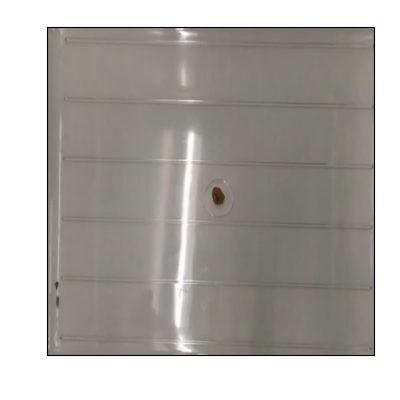

In [7]:
class VideoView:
    def __init__(self):
        self.fig = plt.figure('Video', figsize=(4,4))
        self.ax = plt.gca()
        
        self.fig.tight_layout()
        self.ax.yaxis.set_visible(False)
        self.ax.xaxis.set_visible(False)
        
        self.image = self.ax.imshow(
            controller.subject_analysis.get_frame(controller.frame_index))
        
    def update(self, *args):
        if not controller.update_reference:
            return
            
        # Get the frame
        frame = controller.subject_analysis.get_frame(controller.frame_index)
        
        # Draw the corners on
        zones = get_center_box(controller.subject_analysis, controller.center_size)
        for name, zone in zones.items():
            x, y = np.array(zone).T
            rr, cc = draw.polygon(x, y, shape=controller.subject_analysis.config.box_shape)
            alpha = 0.3
            frame[rr, cc] = (frame[rr, cc]*(1-alpha)).astype('uint8')\
                + (np.array([0, 0, 255])*alpha).astype('uint8')

        self.image.set_data(frame)

video_view = VideoView()
plt.show()
video_view.update()

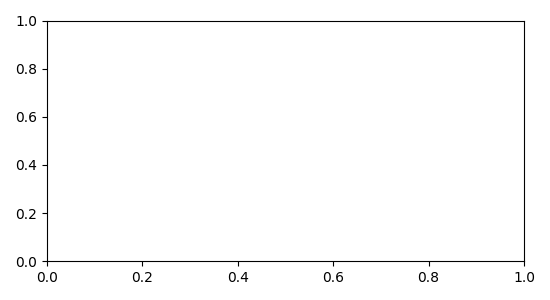

In [18]:
class HistogramTreatmentGroupMeansView:
    def __init__(self):
        self.fig = plt.figure('Hist Treatment Group Means', figsize=(5.5,3))
        self.ax = plt.gca()
        self.fig.tight_layout()

    def display(self):
        plt.show()
        
    def update(self, *args):
        if not controller.update_barplots:
            return
            
        self.ax.clear()
        sns.histplot(data=model.results_with_treatment, hue='injected_with', x='ratio_time_in_center', ax=self.ax, multiple='dodge', kde=True)
        
hist_treatment_group_means_view = HistogramTreatmentGroupMeansView()
hist_treatment_group_means_view.display()
hist_treatment_group_means_view.update()


### Treatment Group Means

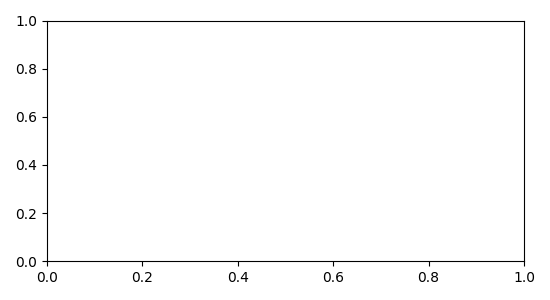

In [19]:
class TreatmentGroupMeansView:
    def __init__(self):
        self.fig = plt.figure('Treatment Group Means', figsize=(5.5,3))
        self.ax = plt.gca()
        self.fig.tight_layout()

    def display(self):
        plt.show()
        
    def update(self, *args):
        if not controller.update_barplots:
            return
            
        self.ax.clear()
        sns.barplot(data=model.results_with_treatment, x='injected_with', y='ratio_time_in_center', ax=self.ax)
        
treatment_group_means_view = TreatmentGroupMeansView()
treatment_group_means_view.display()
treatment_group_means_view.update()


### Treatment/Sex Group Means

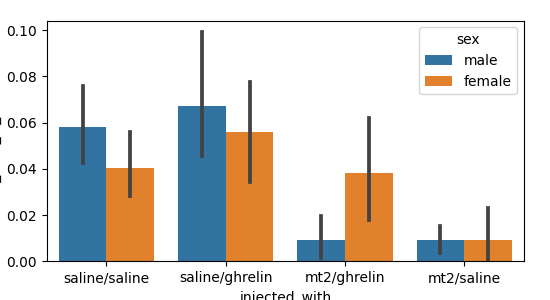

In [20]:
class TreatmentSexGroupMeansView:
    def __init__(self):
        self.fig = plt.figure('Treatment Sex Group Means', figsize=(5.5,3))
        self.ax = plt.gca()
        self.fig.tight_layout()

    def update(self, *args):
        if not controller.update_barplots:
            return
            
        self.ax.clear()
        sns.barplot(data=model.results_with_treatment, x='injected_with', y='ratio_time_in_center', hue='sex', ax=self.ax)
        
treatment_sex_group_means_view = TreatmentSexGroupMeansView()
treatment_sex_group_means_view.update()
plt.show()

## Statistics

In [11]:
from scipy.stats import kstest, shapiro, kruskal, mannwhitneyu
from itertools import combinations

class StatsView:
    def __init__(self):
        self.output = widgets.Output()
    
    def display(self):
        display(self.output)
        
    def update(self):
        if not controller.update_stats:
            return
            
        self.output.clear_output()
        with self.output:
            groups = model.results_with_treatment.groupby(['treatment1', 'treatment2'])
            alpha = 0.05
            
            display(HTML("<h2>Shapiro-Wilk: Normality</h2>"))
            results = groups.apply(lambda x: shapiro(x.ratio_time_in_center.values))
            results = pd.DataFrame(
                results.apply(lambda x: {'F': x[0], 'pvalue': x[1]}).tolist(),
                index=results.index)
            display(results)
            
            display(HTML("<h2>Kruskal-Wallis: Group Differences</h2>"))
            groups = model.results_with_treatment.groupby(['treatment1', 'treatment2'])
            results = kruskal(*groups.apply(lambda x: x.ratio_time_in_center.tolist()).values)
            print(f"kruskal-wallis pvalue: {results.pvalue:.4f}")
            
            display(HTML("<h2>Mannwhitney: Paired Differences</h2>"))
            results = {}
            group_names = list(groups.indices.keys())
            for g1, g2 in combinations(group_names, r=2):
                l1 = '/'.join(g1)
                l2 = '/'.join(g2)
                results[(l1,l2)] = mannwhitneyu(
                    groups.get_group(g1).ratio_time_in_center, 
                    groups.get_group(g2).ratio_time_in_center)

            results = pd.DataFrame(results, index=['F', 'pvalue']).T
            bonferonni_alpha = alpha / results.shape[0]
            
            results = results.style.applymap(
                lambda x: 'color: red' if x < bonferonni_alpha else '', subset=['pvalue'])
            display(results)
                
            display(HTML("<h2>Kolmogorov-Smirnov: Matching Distributions</h2>"))
            results = {}
            group_names = list(groups.indices.keys())
            for g1, g2 in combinations(group_names, r=2):
                l1 = '/'.join(g1)
                l2 = '/'.join(g2)
                results[(l1,l2)] = kstest(
                    groups.get_group(g1).ratio_time_in_center, 
                    groups.get_group(g2).ratio_time_in_center)

            results = pd.DataFrame(results, index=['F', 'pvalue']).T
            results = results.style.applymap(
                lambda x: 'color: red' if x < bonferonni_alpha else '', subset=['pvalue'])
            display(results)
            
stats_view = StatsView()
stats_view.display()
stats_view.update()

F    pvalue
treatment1 treatment2                    
mt2        ghrelin     0.810887  0.002872
           saline      0.684444  0.000053
saline     ghrelin     0.919404  0.096503
           saline      0.931292  0.228731

kruskal-wallis pvalue: 0.0000


### Jenson-Shannon (KL-Divergence) 

In [12]:
from scipy.special import rel_entr

class JSEntropyView:
    def __init__(self):
        self.output = widgets.Output()
        
    def display(self):
        display(self.output)
        
    def update(self, *args):
        if not controller.update_stats:
            return
        
        self.output.clear_output()
        with self.output:
            groups = model.results_with_treatment.groupby(['treatment1', 'treatment2'])
            hist = groups.apply(
                lambda x: np.histogram(x.ratio_time_in_center.values, density=True)[0])


            results = {}
            for g1, g2 in combinations(groups.indices.keys(), r=2):
                h1 = hist.loc[g1]
                h2 = hist.loc[g2]
                js = sum(rel_entr(h1, h2)[h2!=0]) + sum(rel_entr(h2, h1)[h1!=0])
                l1 = '/'.join(g1)
                l2 = '/'.join(g2)
                results[(l1, l2)] = js

            results = pd.DataFrame(results, index=['JS entropy']).T
            
            display(HTML("<h2>JS Entropy</h2>"))
            display(results)
            
js_entropy_view = JSEntropyView()
js_entropy_view.display()
js_entropy_view.update()

JS entropy
mt2/ghrelin    mt2/saline       88.012919
               saline/ghrelin   67.196201
               saline/saline   135.080055
mt2/saline     saline/ghrelin  292.873909
               saline/saline   403.428938
saline/ghrelin saline/saline    69.802879

### Correlation

In [13]:
class CorrelationView:
    def __init__(self):
        self.output = widgets.Output()
        
    def display(self):
        display(self.output)
        
    def update(self, *args):
        if not controller.update_stats:
            return
        
        self.output.clear_output()
        with self.output:
            corr = model.results_with_treatment[['ratio_time_in_center', 'time_eating']].corr()
            corr.columns = ['automatic', 'manual']
            corr.index = ['automatic', 'manual']
            
            display(HTML("<h2>Manual-Automatic Correlation</h2>"))
            display(HTML("<i> Time Eating </i>"))
            display(corr)
            
correlation_view = CorrelationView()
correlation_view.display()
correlation_view.update()

,automatic,manual
automatic,1.000000,0.686681
manual,0.686681,1.000000


In [14]:
manual = model.results_with_treatment.time_in_corner
automatic = model.results_with_treatment.ratio_time_in_center
differences = manual - automatic * model.results_with_treatment.total_time/30

pd.DataFrame([differences]).T.sort_values(by=0, ascending=False)

,0
animal,
f20,540.000000
f32,540.000000
f35,522.980000
m28,509.660000
f36,505.730000
...,...
m2,71.010000
f15,60.760000
f14,58.933333


## Events

In [15]:
controller.center_size_slider.observe(model.update_analysis)
controller.time_slice_slider.observe(model.update_time_range)
controller.analsis_button.on_click(model.update_analysis)
controller.analsis_button.on_click(video_view.update)

In [37]:
model.observe(treatment_group_means_view.update)
model.observe(treatment_sex_group_means_view.update)
model.observe(hist_treatment_group_means_view.update)
model.observe(correlation_view.update)
model.observe(js_entropy_view.update)
model.observe(stats_view.update)

# Video
controller.frame_index_slider.observe(video_view.update)
controller.video_dropdown.observe(video_view.update)
controller.center_size_slider.observe(video_view.update)

## Notes
- Center size of ~59 for the whole video sees sig results for 4 groups (excluding saline/ghrelin differences)
- A size of ~87, with a time range stretching ~the first 50% of videos has all pvalues<0.05 (but we use bonferonni here). The KS pvalus are also low however